In [1]:
using RCall, Gadfly, DataFrames
addprocs(7);
import Lazy.@>, Lazy.@>>


Attaching package: ‘dplyr’

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

data.table 1.9.6  For help type ?data.table or https://github.com/Rdatatable/data.table/wiki
The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last



In [3]:
using LogTopReg
include("../juliafromR.jl");
Y,X,pss0 = getfocaldata();

  Bumped column 18 to type character on data row 6, field contains 'Activity (rest)'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses the first 5 rows, the middle 5 rows and the last 5 rows, so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.
Warning in fread(files[i]) :
  Bumped column 19 to type character on data row 6, field contains 'In 2m? (8)'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they wil

In [6]:
K = repeat(collect(2:9),inner=[5]);
@time fit = @parallel (vcat) for k in K
    topiclmm(Y,X,pss0,k,250,1);
end;
lp = pmap(lppd,fit,fill(Y,length(K)));

208.573829 seconds (13.38 M allocations: 999.833 MB, 0.13% gc time)


In [7]:
ns = length(fit[1][:τ])

250

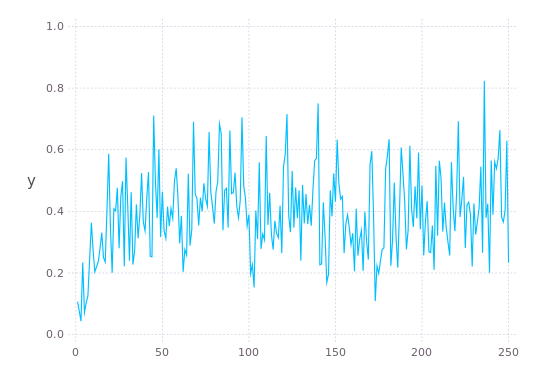

In [21]:
i = 25;
plot(y=fit[i][:τ]./(fit[i][:τ]+1),Geom.line)

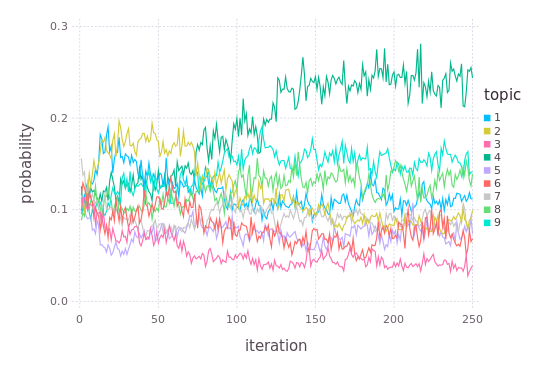

In [68]:
i = 37;
mudat = DataFrame(probability = mapslices(softmax,fit[i][:μ],1)[:],topic=repeat(map(string,1:K[i]),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K[i]]));
plot(mudat,x="iteration",y="probability",color="topic",Geom.line)

In [29]:
lpdat = DataFrame(loglik=vcat(map(y -> sum(hcat(y...),2),lp)...)[:],chain=repeat(map(string,1:length(K)),inner=[ns]),
iter=repeat(collect(1:ns),outer=[length(K)]),K=repeat(K,inner=[ns]));

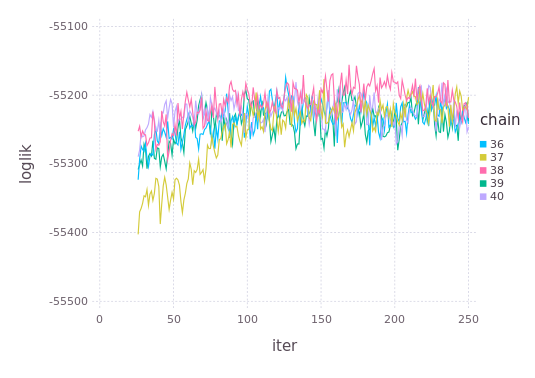

In [70]:
plot(lpdat[(lpdat[:K].==9) & (lpdat[:iter].>25),:],y="loglik",x="iter",color="chain",Geom.line)

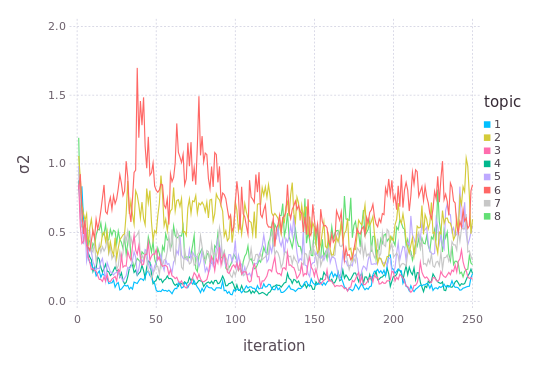

In [43]:
i = 35;
sigdat = DataFrame(σ2 = fit[i][:σ2][:],topic=repeat(map(string,1:K[i]),
outer=[ns]),iteration=repeat(collect(1:ns),inner=[K[i]]));
plot(sigdat,y="σ2",x="iteration",color="topic",Geom.line)

In [75]:
warmup = 100;
loo = Vector{Dict{Symbol,Any}}(length(K))
rcopy("library(loo)");
for i in 1:length(K)
    globalEnv[:lp] = hcat(lp[i]...)[(warmup+1):ns,:];
    loo[i] = rcopy("loo(lp)");
end

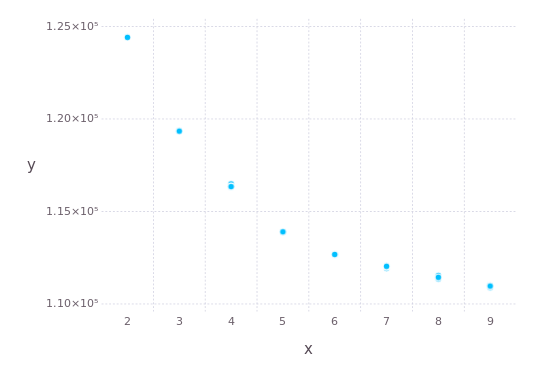

In [83]:
plot(y=[loo[i][:looic] for i=1:length(K)],x=map(string,K),Geom.point)

In [109]:
map(y -> hcat(map(x -> sum(x,2),y)...),lp)

40-element Array{Any,1}:
 [-816.685,-774.567,-751.829,-748.679,-748.953,-749.494,-747.216,-749.091,-747.55,-746.257,-746.405,-746.125,-745.841,-745.753,-746.856,-746.936,-747.265,-746.415,-747.165,-746.442,-748.05,-746.04,-746.264,-746.035,-746.163,-745.937,-746.694,-746.109,-745.653,-745.37,-746.09,-746.971,-746.772,-746.798,-746.003,-745.131,-745.072,-745.631,-745.515,-745.167,-745.944,-745.553,-745.876,-747.955,-745.985,-745.852,-745.522,-745.886,-747.724,-746.168,-746.623,-746.18,-745.732,-746.089,-746.023,-746.056,-747.451,-746.483,-747.04,-748.185,-745.585,-746.982,-746.278,-747.987,-746.778,-748.201,-747.046,-746.411,-746.429,-746.255,-747.01,-747.254,-745.544,-746.262,-746.683,-746.918,-746.995,-746.981,-748.208,-747.931,-746.676,-749.213,-747.947,-746.0,-745.552,-746.374,-746.801,-746.609,-747.378,-747.084,-746.324,-746.286,-746.305,-746.704,-747.182,-748.78,-746.569,-747.762,-746.222,-746.433,-745.627,-745.83,-745.994,-748.261,-745.754,-745.924,-745.525,-747.983,-746.355,-746

In [94]:
import LogTopReg.lppd
function lppd{T<:Real}(fit::Dict{Symbol,AbstractArray},y::Vector{Array{T,2}},pointwise::Bool=true)
  n = length(y);
  m = length(fit[:τ]);
  nd = map(i -> size(y[i])[2],1:n);
  lp = Array{Array{Float64,2}}(n);
  for i in 1:n lp[i] = Array{Float64}(m,nd[i]); end

  for i in 1:n
    for j in 1:m
      π = softmax(fit[:η][:,i,j]);
      lp[i][j,:] = lppd(fit[:topic][:,j],π,y[i]);
    end

    if !pointwise lp[i] = sum(lp[i],2); end
  end

  if !pointwise lp = hcat(lp...); end
  return lp
end



lppd (generic function with 10 methods)